In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from datasets import Dataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
warnings.filterwarnings("ignore", category=ConvergenceWarning, module='sklearn')

In [2]:
from datasets import load_dataset

try:
    # Load the dataset
    dataset = load_dataset("medalpaca/medical_meadow_medical_flashcards")
    print(dataset)

    # Save the dataset to disk
    save_path = '/kaggle/working/medical_meadow_dataset'
    dataset.save_to_disk(save_path)
    print(f"Dataset saved successfully to {save_path}")
except Exception as e:
    print(f"An error occurred: {e}")

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output', 'input'],
        num_rows: 33955
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/33955 [00:00<?, ? examples/s]

Dataset saved successfully to /kaggle/working/medical_meadow_dataset


In [3]:
# Load the dataset from the saved arrow file
dataset = Dataset.from_file('/kaggle/working/medical_meadow_dataset/train/data-00000-of-00001.arrow')

# Convert to Pandas DataFrame for analysis
df = dataset.to_pandas()

# Briefly describe the dataset
print(f"Dataset contains {len(df)} documents.")
print(df.head())

Dataset contains 33955 documents.
                       instruction  \
0  Answer this question truthfully   
1  Answer this question truthfully   
2  Answer this question truthfully   
3  Answer this question truthfully   
4  Answer this question truthfully   

                                              output  \
0  Very low Mg2+ levels correspond to low PTH lev...   
1  Low estradiol production leads to genitourinar...   
2  Low REM sleep latency and experiencing halluci...   
3  PTH-independent hypercalcemia, which can be ca...   
4  The level of anti-müllerian hormone is directl...   

                                               input  
0  What is the relationship between very low Mg2+...  
1  What leads to genitourinary syndrome of menopa...  
2  What does low REM sleep latency and experienci...  
3  What are some possible causes of low PTH and h...  
4  How does the level of anti-müllerian hormone r...  


In [11]:
# Tokenize the 'output' column to find frequent terms
output_text = ' '.join(df['output'].astype(str).tolist())
tokens = output_text.lower().split()
common_terms = [term for term, count in Counter(tokens).most_common(50)]
print(f"Most common terms: {common_terms}")

Most common terms: ['the', 'of', 'and', 'is', 'to', 'a', 'in', 'can', 'that', 'as', 'for', 'with', 'are', 'or', 'which', 'by', 'be', 'may', 'it', 'this', 'such', 'an', 'other', 'treatment', 'blood', 'cause', 'on', 'symptoms', 'important', 'used', 'from', 'condition', 'type', 'typically', 'these', 'include', 'lead', 'also', 'risk', 'not', 'when', 'associated', 'cells', 'including', 'have', 'patients', 'if', 'caused', 'their', 'help']


In [12]:
# Define relevant common medical terms based on frequent terms analysis
relevant_terms = ['treatment', 'symptoms', 'patient', 'blood', 'cause', 'condition', 'risk', 'cells', 'patients', 'associated']

# Check presence of relevant terms in the dataset
present_terms = [term for term in relevant_terms if df['output'].str.contains(term, case=False, na=False).any()]
print(f"Present terms: {present_terms}")

Present terms: ['treatment', 'symptoms', 'patient', 'blood', 'cause', 'condition', 'risk', 'cells', 'patients', 'associated']


In [13]:
# Filter the dataset to only include these present relevant terms
filtered_df = df[df['output'].str.contains('|'.join(present_terms), case=False, na=False)]

# Update X and y after filtering
X = filtered_df['input']
y = filtered_df['output']

# Ensure that y only contains our relevant terms
y = y.apply(lambda ans: next((term for term in present_terms if term in ans.lower()), 'other'))

In [14]:
# Print the class distribution before further filtering
print("Class distribution before filtering 'other':")
print(y.value_counts())

# Check the final class distribution to ensure the dataset is ready for training
print("Final class distribution:")
print(y.value_counts())

Class distribution before filtering 'other':
output
treatment     7085
cause         3437
patient       2459
symptoms      2196
blood         1894
associated    1281
cells         1087
condition      698
risk           627
Name: count, dtype: int64
Final class distribution:
output
treatment     7085
cause         3437
patient       2459
symptoms      2196
blood         1894
associated    1281
cells         1087
condition      698
risk           627
Name: count, dtype: int64


Accuracy: 0.57
F1-score: 0.54
Best hyperparameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Classification Report:
              precision    recall  f1-score   support

  associated       0.49      0.83      0.62       236
       blood       0.48      0.52      0.50       413
       cause       0.56      0.60      0.58       682
       cells       0.55      0.69      0.61       223
   condition       0.22      0.31      0.26       144
     patient       0.70      0.72      0.71       502
        risk       0.44      0.74      0.56       124
    symptoms       0.47      0.38      0.42       434
   treatment       0.72      0.54      0.62      1395

    accuracy                           0.57      4153
   macro avg       0.52      0.59      0.54      4153
weighted avg       0.60      0.57      0.58      4153



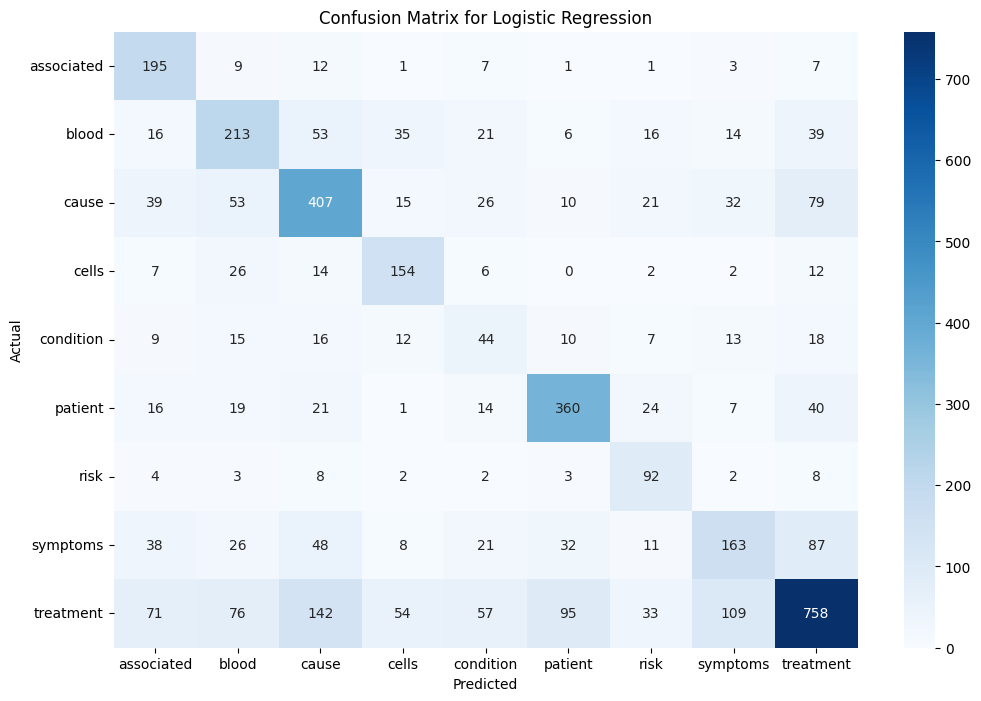

In [21]:
# Check if the dataset is empty after filtering
if len(filtered_df) == 0:
    print("No data available for the specified relevant terms.")
else:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert text data to TF-IDF features
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    # Define hyperparameter grid for Logistic Regression
    param_grid = {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs', 'liblinear'],
        'penalty': ['l2'],  # Only l2 penalty is compatible with 'lbfgs'
        'class_weight': ['balanced', None]
    }
    
    # Train and evaluate Logistic Regression
    model = LogisticRegression(max_iter=5000)
    clf = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
    clf.fit(X_train_tfidf, y_train)

    y_pred = clf.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Print results
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1-score: {f1:.2f}")
    print(f"Best hyperparameters: {clf.best_params_}")

    # Detailed evaluation
    unique_labels = np.unique(np.concatenate((y_test, y_pred)))

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=unique_labels))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred, labels=unique_labels)
    plt.figure(figsize=(12, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
    plt.title('Confusion Matrix for Logistic Regression')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()